# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=fb7be4f6d6ba0432334889fab17720c8a45b036f3f76d99b09f97f2dc9e295b2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=356142e450f675c361ab083859fffd709f078ca1fc53c9dafbb49389d5181abe
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 32.31 MiB/s, done.
Resolving deltas: 100% (3/3), done.


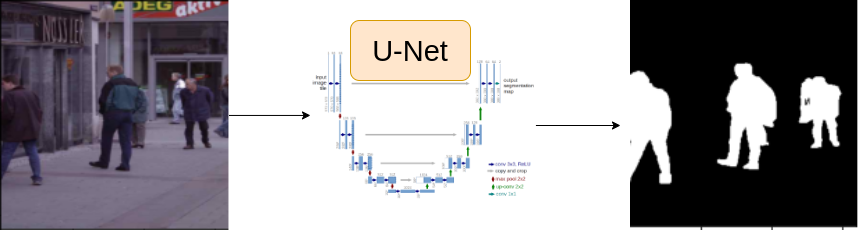

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
DEVICE = 'cuda'

epochs = 25
learning_rate = 0.003
batch_size = 16

# image size represents the width and height that we will scale down all images to
image_size = 320

#encoder used for scaling down images in the Unet
encoder = 'timm-efficientnet-b0'
# imagenet is a starting point for the weights for image recognition tasks
weights = 'imagenet'

In [6]:
overall_df = pd.read_csv('/content/Human-Segmentation-Dataset-master/train.csv')
overall_df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = overall_df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Open CV reads images in BGR format, need to convert to RGB (colors will be inverted without this)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

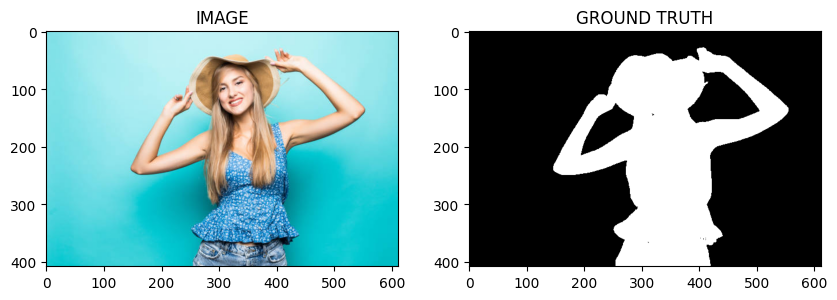

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
# train test split
train_df, test_df = train_test_split(overall_df, test_size = 0.2, train_size = 0.8, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
# Augmentation is done to create more training examples from pictures. An example is rotating the image, flipping the image, or making the image more blurry.
# Addition of these examples makes the model more accurate. We are 'augmenting' an existing example to create a new example.

# REMEMBER: you have to augment both the image and the mask in this example. For classification tasks, the label (cat/dog) stays the same
# BUT, in image segmentation, you have to augment both the image and the mask.
import albumentations as A

# Task 4 : Create Custom Dataset

In [11]:
from torch.utils.data import Dataset

In [12]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augments):
    self.df = df
    self.augments = augments

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]

    image_path = row.images
    mask_path = row.masks
    image = cv2.imread(image_path)
    # Open CV reads images in BGR format, need to convert to RGB (colors will be inverted without this)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # dimensions of mask is (h, w), we need to add another dimension of channel (h, w, c)
    mask = np.expand_dims(mask, axis=-1)

    # Augmentations
    if self.augments:
      data = self.augments(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # Pytorch uses (c, h, w) format, and we currently have (h, w, c)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    # Convert to Tensor

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask

In [13]:
training_set = SegmentationDataset(train_df, A.Compose([A.Resize(image_size, image_size), A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)], is_check_shapes=False))
test_set = SegmentationDataset(test_df, A.Compose([A.Resize(image_size, image_size)], is_check_shapes=False))

In [14]:
print(f"Size of Trainset : {len(training_set)}")
print(f"Size of Validset : {len(test_set)}")

Size of Trainset : 232
Size of Validset : 58


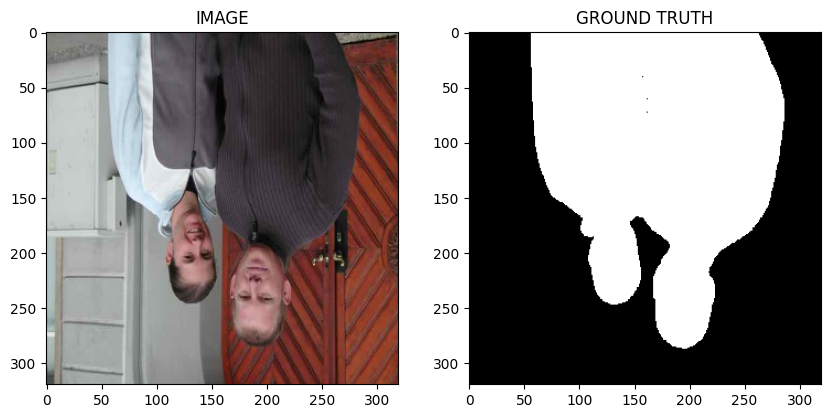

In [15]:
index = 57
image, mask = training_set[index]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [16]:
from torch.utils.data import DataLoader

In [17]:
trainloader = DataLoader(training_set, batch_size=batch_size, shuffle= True)
testloader= DataLoader(test_set, batch_size=batch_size)

In [18]:
print(len(trainloader))
print(len(testloader))

15
4


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [19]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [20]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    # Implementing Unet architecture (model)
    self.arc = smp.Unet(
        encoder_name = 'timm-efficientnet-b0',
        encoder_weights = 'imagenet',
        in_channels=3, # 3 input channels, RGB
        classes = 1, # 1 output channel, the mask (black/white)
        activation = None # we are going to use softmax activation, which requires no activation
    )

  def forward (self, images, masks = None):
    logits = self.arc(images)

    # calculate loss if masks is not None
    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [21]:
model = SegmentationModel()
model.to(device = 'cuda'); #use gpu cores

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 81.1MB/s]


# Task 7 : Create Train and Validation Function

In [22]:
def train_model(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader): #tqdm just shows a progress bar

    # shift to gpu cores
    images = images.to('cuda')
    masks = masks.to('cuda')

    # INVESTIGATE: What does zero grad do?
    optimizer.zero_grad()

    # invoke model
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # return average loss
  return total_loss / len(data_loader)

In [23]:
def test_model(data_loader, model):
  model.eval()
  total_loss = 0.0

  # turns off gradient computations
  with torch.no_grad():
    for images, masks in tqdm(data_loader): #tqdm just shows a progress bar

      # shift to gpu cores
      images = images.to('cuda')
      masks = masks.to('cuda')

      logits, loss = model(images, masks)

      total_loss += loss.item()

    # return average loss
    return total_loss / len(data_loader)

# Task 8 : Train Model

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)

In [25]:
best_loss = np.Inf

for i in range(epochs):
  train_loss = train_model(trainloader, model, optimizer)
  valid_loss = test_model(testloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_loss = valid_loss
    print("SAVED MODEL")

  print(f"epoch: {i + 1}, train loss: {train_loss}, test loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


SAVED MODEL
epoch: 1, train loss: 0.7713343898455302, test loss: 0.6225816830992699


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


epoch: 2, train loss: 0.3816385050614675, test loss: 1.0897842049598694


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


SAVED MODEL
epoch: 3, train loss: 0.3334090272585551, test loss: 0.3268261253833771


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


SAVED MODEL
epoch: 4, train loss: 0.29938967327276866, test loss: 0.27447012066841125


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


SAVED MODEL
epoch: 5, train loss: 0.226874245206515, test loss: 0.24216371774673462


100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


epoch: 6, train loss: 0.19332129508256912, test loss: 0.2779455855488777


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


SAVED MODEL
epoch: 7, train loss: 0.23129346271355947, test loss: 0.20035215467214584


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


epoch: 8, train loss: 0.20194219251473744, test loss: 0.27010707184672356


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


epoch: 9, train loss: 0.20651145428419113, test loss: 0.28047437220811844


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


epoch: 10, train loss: 0.19079907089471818, test loss: 0.20192015543580055


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


epoch: 11, train loss: 0.16706249217192332, test loss: 0.24213633313775063


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


epoch: 12, train loss: 0.13613224724928538, test loss: 0.213969849050045


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


epoch: 13, train loss: 0.15484971851110457, test loss: 0.22678768262267113


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


epoch: 14, train loss: 0.1498330906033516, test loss: 0.24992909096181393


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


epoch: 15, train loss: 0.14665048817793527, test loss: 0.2538364566862583


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


SAVED MODEL
epoch: 16, train loss: 0.11964618762334188, test loss: 0.18132873624563217


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


epoch: 17, train loss: 0.1829996054371198, test loss: 0.23735026642680168


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


epoch: 18, train loss: 0.11070986340443294, test loss: 0.2219767663627863


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


epoch: 19, train loss: 0.16446042507886888, test loss: 0.29677098244428635


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


epoch: 20, train loss: 0.15199935932954153, test loss: 0.2428426407277584


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


epoch: 21, train loss: 0.13419905205567678, test loss: 0.27505897730588913


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


epoch: 22, train loss: 0.12444477876027425, test loss: 0.21940883807837963


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


epoch: 23, train loss: 0.125167120496432, test loss: 0.21345777809619904


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


epoch: 24, train loss: 0.11223076631625493, test loss: 0.2270362377166748


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

epoch: 25, train loss: 0.11903628210226695, test loss: 0.22902975603938103


# Task 9 : Inference

In [26]:
model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = test_set[18]

# we have only calculated the logits mask. We still have to apply the sigmoid function to get a binary value (0, 1) for each pixel for the mask
logits_mask = model(image.to('cuda').unsqueeze(0)) # add another dimension of batch size

predicted_mask = torch.sigmoid(logits_mask)


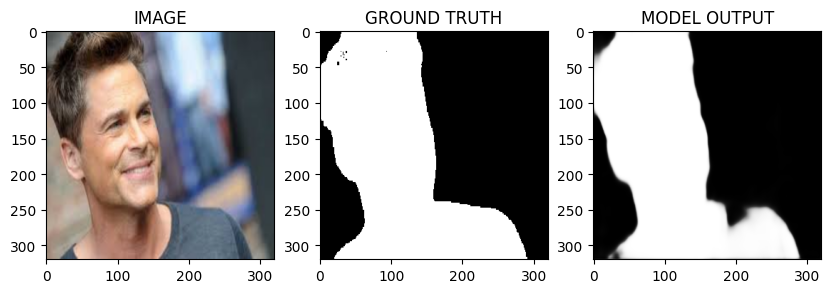

In [27]:
helper.show_image(image, mask, predicted_mask.detach().cpu().squeeze(0))
# .detach() to convert back from numpy to Tensor, .cpu() to move image back to cpu, .squeeze() to remove the batch dimension